In [17]:
# import luh
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import joblib

In [7]:
# load dataset
data = pd.read_csv("fyp_dataset.csv")

In [9]:
# data exploration
print(data.info())
print(data.describe())
print("Missing Values:\n", data.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 35 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital status                                  4424 non-null   int64  
 1   Application mode                                4424 non-null   int64  
 2   Application order                               4424 non-null   int64  
 3   Course                                          4424 non-null   int64  
 4   Daytime/evening attendance                      4424 non-null   int64  
 5   Previous qualification                          4424 non-null   int64  
 6   Nacionality                                     4424 non-null   int64  
 7   Mother's qualification                          4424 non-null   int64  
 8   Father's qualification                          4424 non-null   int64  
 9   Mother's occupation                      

In [11]:
# encode target
le = LabelEncoder()
data['Target'] = le.fit_transform(data['Target'])

In [15]:
# define
# Define Features and Target
X = data.drop('Target', axis=1)
y = data['Target']

In [21]:
# identify irrelevant features
irrelevant_features = []

X = data.drop('Target', axis=1)
y = data['Target']

for column in X.columns:
    contingency_table = pd.crosstab(X[column], y)
    
    chi2, p, _, _ = chi2_contingency(contingency_table)
    
    # check if p-value > 0.05 
    if p > 0.05:
        irrelevant_features.append(column)
        print(f"Feature '{column}' is likely irrelevant with p-value: {p:.4f}")

print("Irrelevant Features:", irrelevant_features)

Feature 'Nacionality' is likely irrelevant with p-value: 0.2422
Feature 'Educational special needs' is likely irrelevant with p-value: 0.7254
Feature 'International' is likely irrelevant with p-value: 0.5273
Irrelevant Features: ['Nacionality', 'Educational special needs', 'International']


In [47]:
X = X.drop(columns=irrelevant_features)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [27]:
# scaling - standardization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [33]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [55]:
log_reg_model = LogisticRegression(max_iter=1000, random_state=42, multi_class='multinomial', solver='lbfgs')
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

In [57]:
# hyperparameter tuning with GridSearchCV
param_grid_log_reg = {'C': [0.1, 1, 10], 'solver': ['lbfgs', 'saga']}
grid_search_log_reg = GridSearchCV(log_reg_model, param_grid_log_reg, cv=cv, scoring='accuracy')
grid_search_log_reg.fit(X_train, y_train)

param_grid_rf = {'n_estimators': [100, 200], 'max_depth': [None, 10, 20]}
grid_search_rf = GridSearchCV(rf_model, param_grid_rf, cv=cv, scoring='accuracy')
grid_search_rf.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [None, 10, 20],
                         'n_estimators': [100, 200]},
             scoring='accuracy')

In [37]:
# show best parameter
# Display Best Parameters
print(f"Best Logistic Regression Parameters: {grid_search_log_reg.best_params_}")
print(f"Best Random Forest Parameters: {grid_search_rf.best_params_}")

Best Logistic Regression Parameters: {'C': 10, 'solver': 'lbfgs'}
Best Random Forest Parameters: {'max_depth': 20, 'n_estimators': 100}


In [63]:
# train final fodels with best parameters
log_reg_model = LogisticRegression(**grid_search_log_reg.best_params_, max_iter=1000, random_state=42, multi_class='multinomial')
log_reg_model.fit(X_train, y_train)

rf_model = RandomForestClassifier(**grid_search_rf.best_params_, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, random_state=42)

Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.75      0.76       284
           1       0.50      0.32      0.39       159
           2       0.79      0.92      0.85       442

    accuracy                           0.75       885
   macro avg       0.69      0.66      0.67       885
weighted avg       0.74      0.75      0.74       885



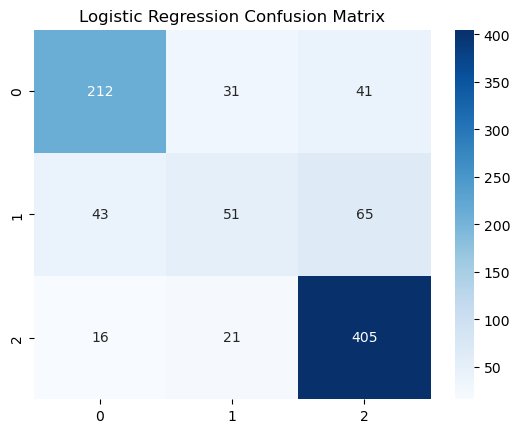

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.75      0.78       284
           1       0.57      0.37      0.45       159
           2       0.80      0.94      0.86       442

    accuracy                           0.78       885
   macro avg       0.73      0.69      0.70       885
weighted avg       0.76      0.78      0.76       885



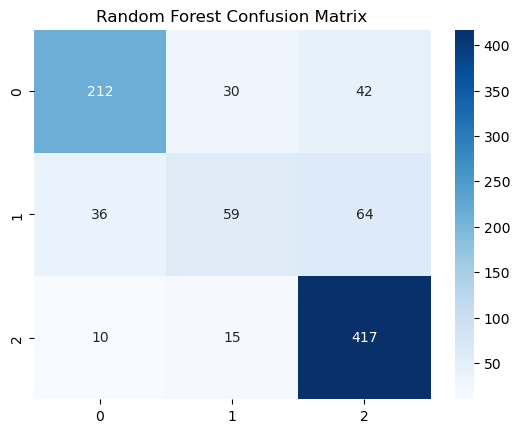

In [65]:
# model Evaluation - classification report and confusion matrix
y_pred_log_reg = log_reg_model.predict(X_test)
print("Logistic Regression Classification Report:\n", classification_report(y_test, y_pred_log_reg))
sns.heatmap(confusion_matrix(y_test, y_pred_log_reg), annot=True, fmt="d", cmap="Blues")
plt.title("Logistic Regression Confusion Matrix")
plt.show()

y_pred_rf = rf_model.predict(X_test)
print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt="d", cmap="Blues")
plt.title("Random Forest Confusion Matrix")
plt.show()

In [67]:
# save models and preprocessing objects
joblib.dump(log_reg_model, "logistic_regression_model.pkl")
joblib.dump(rf_model, "random_forest_model.pkl")
joblib.dump(le, "label_encoder.pkl")
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']

In [51]:
from sklearn.metrics import accuracy_score

# Train the final models on the training set
log_reg_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)

# Predict and calculate accuracy on both training and test sets
# Logistic Regression
train_accuracy_log_reg = accuracy_score(y_train, log_reg_model.predict(X_train))
test_accuracy_log_reg = accuracy_score(y_test, log_reg_model.predict(X_test))

# Random Forest
train_accuracy_rf = accuracy_score(y_train, rf_model.predict(X_train))
test_accuracy_rf = accuracy_score(y_test, rf_model.predict(X_test))

# Print the results for overfitting evaluation
print(f"Logistic Regression - Training Accuracy: {train_accuracy_log_reg}")
print(f"Logistic Regression - Test Accuracy: {test_accuracy_log_reg}")
print(f"Random Forest - Training Accuracy: {train_accuracy_rf}")
print(f"Random Forest - Test Accuracy: {test_accuracy_rf}")

# Interpretation
if train_accuracy_log_reg > test_accuracy_log_reg:
    print("Logistic Regression might be overfitting.")
if train_accuracy_rf > test_accuracy_rf:
    print("Random Forest might be overfitting.")


Logistic Regression - Training Accuracy: 0.7767730997456909
Logistic Regression - Test Accuracy: 0.7548022598870057
Random Forest - Training Accuracy: 0.9983046058208533
Random Forest - Test Accuracy: 0.7774011299435029
Logistic Regression might be overfitting.
Random Forest might be overfitting.


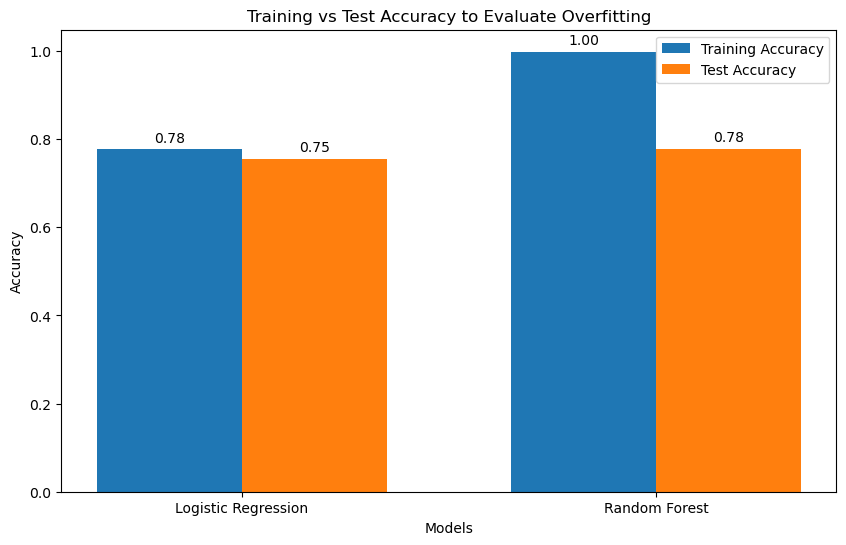

In [69]:
import matplotlib.pyplot as plt
import numpy as np

# Training and test accuracies for each model
train_accuracies = [train_accuracy_log_reg, train_accuracy_rf]
test_accuracies = [test_accuracy_log_reg, test_accuracy_rf]
models = ['Logistic Regression', 'Random Forest']

# Plotting
x = np.arange(len(models))  # Label locations
width = 0.35  # Width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
train_bars = ax.bar(x - width/2, train_accuracies, width, label='Training Accuracy')
test_bars = ax.bar(x + width/2, test_accuracies, width, label='Test Accuracy')

# Labels and Title
ax.set_xlabel('Models')
ax.set_ylabel('Accuracy')
ax.set_title('Training vs Test Accuracy to Evaluate Overfitting')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

# Adding accuracy labels on the bars
for bar in train_bars + test_bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f"{yval:.2f}", ha='center', va='bottom')

plt.show()
